In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import roc_auc_score

from plotnine import *

pd.options.mode.chained_assignment = None  # default='warn'

# Ignore all future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 1. Tuning the Hashing Dimension

Using the train.csv dataset from Lab 3, split the data into training, validation, and testing sets, using test_train_split and setting the random state equal to 5.

In [3]:
def read_csv_from_drive(url: str) -> pd.DataFrame:
  url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
  return pd.read_csv(url)

# Read data from csv file and drop the 'id' column as it won't be needed.
data = read_csv_from_drive(
  'https://drive.google.com/file/d/1Q8Q62LS3XY3yjJOIWTM-cAN-9FlOHMOU/view?usp=drive_link'
).drop(columns = ['id'])
data.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,...,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,...,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,...,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,...,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,...,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


In [4]:
def split_sets(data: pd.DataFrame,
               target_column_name: str = 'target',
               test_size: float = 0.2,
               validation_size: float = 0.20,
               seed: int = 8675309) -> tuple:
  """Split a data frame into train/validation/test sets.

  Args:
    data (pd.DataFrame): The data we'd like to split.
    target_column_name (str): The column name in the data containing the target.
    test_size (float): The proportion of the data to use for test.
    validation_size (float): The proportion of training data to use for
      validation.
    seed (int): A seed to supply to train_test_split.

  Returns:
    A tuple containing the train/validation/test sets for both the targets (Y)
    and features (X).
  """

  # Extract the Y and X values from the data.
  Y = data[target_column_name].values
  X = data.drop(columns=[target_column_name])

  # Split data into (validation + train) and test.
  x_train_val, x_test, y_train_val, y_test = train_test_split(
      X, Y, test_size = test_size, random_state = seed)
  x_train_val = x_train_val.reset_index(drop = True)
  x_test = x_test.reset_index(drop = True)

  # Split again into validation and train.
  x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val, test_size = validation_size, random_state = seed)

  return (
    x_train, y_train, x_val, y_val, x_test, y_test, x_train_val, y_train_val
  )

In [5]:
x_train, y_train, x_val, y_val, x_test, y_test, x_train_val, y_train_val = (
  split_sets(data)
)

Ensure that:
- the binary variables are dummy encoded,
- numeric variables are left alone,
- the variables ’ord_0’, ’ord_3’, ’ord_4’, & ’ord_5’ are label encoded, and
- the variables ’nom_0’, ’nom_1’, ’nom_2’, ’nom_3’, ’nom_4’, ’nom_5’, ’nom_6’, ’nom_7’, ’nom_8’, ’nom_9’, ’ord_1’, & ’ord_2’ are encoded with hashing.


In [6]:
{col: len(x_train[col].unique()) for col in x_train.columns}

{'bin_0': 2,
 'bin_1': 2,
 'bin_2': 2,
 'bin_3': 2,
 'bin_4': 2,
 'nom_0': 3,
 'nom_1': 6,
 'nom_2': 6,
 'nom_3': 6,
 'nom_4': 4,
 'nom_5': 222,
 'nom_6': 522,
 'nom_7': 1220,
 'nom_8': 2214,
 'nom_9': 11846,
 'ord_0': 3,
 'ord_1': 5,
 'ord_2': 6,
 'ord_3': 15,
 'ord_4': 26,
 'ord_5': 192,
 'day': 7,
 'month': 12}

In [7]:
def label_encoding(x: np.array,
                   add_unknown: bool = True,
                   unknown_value: str = 'Unknown'):
  """Encode a categorical column.

  Args:
    x (np.array): An array to encode.
    add_unknown (bool): If True, add an 'unknown' label.
    unknown_value (str): The value to use in the 'unknown' label.

  Returns:
    A LabelEncoder.
  """

  le = LabelEncoder()
  uniq = np.unique(x)
  if add_unknown:
    uniq = np.concatenate((np.array([unknown_value]), uniq))
  le.fit(uniq)
  return le

In [8]:
def transform_column(le: LabelEncoder,
                     index: int,
                     x_train: np.array,
                     x_val: np.array,
                     x_test: np.array,
                     x_train_val: np.array,
                     unknown_value: str = 'Unknown') -> None:
  classes = le.classes_

  x_train[index] = le.transform(x_train[index])

  val = [x if x in classes else unknown_value for x in x_val[index]]
  x_val[index] = le.transform(val)

  test = [x if x in classes else unknown_value for x in x_test[index]]
  x_test[index] = le.transform(test)

  train_val = [x if x in classes else unknown_value for x in x_train_val[index]]
  x_train_val[index] = le.transform(train_val)

In [9]:
def hashing_trick(x: pd.DataFrame, n_features: int = 3) -> pd.DataFrame:
  """Create a hash from a column of strings.

  Args:
    x (pd.DataFrame): A single column as a pandas data frame.
    n_features (int): The number of features (columns) in the output matrices.

  Returns:
    A pandas data frame with 1 row and `n_features` columns containing the
    hashed values.
  """

  # Create new columns for output data frame.
  names = [x.name + "_" + str(i + 1) for i in range(n_features)]

  # Build hasher function.
  h = FeatureHasher(input_type = 'string', n_features = n_features)

  # Transform the column and convert to an array.
  hashed = h.transform(x.to_numpy().reshape(-1, 1)).toarray()

  # Add `names` and return hashed field.
  return pd.DataFrame(hashed, columns = names)

In [10]:
def transform_data(x_train: pd.DataFrame,
                   x_val: pd.DataFrame,
                   x_test: pd.DataFrame,
                   x_train_val: pd.DataFrame,
                   n: int)-> pd.DataFrame:
  
  label_encoding_cols = ['bin_3', 'bin_4', 'ord_3', 'ord_4', 'ord_5']
  num_cols = ['bin_0', 'bin_1', 'bin_2', 'ord_0', 'day', 'month']
  hashing_col = ['nom_0',
  'nom_1',
  'nom_2',
  'nom_3',
  'nom_4',
  'nom_5',
  'nom_6',
  'nom_7',
  'nom_8',
  'nom_9',
  'ord_1',
  'ord_2']

  x_train_hash = x_train[hashing_col].copy()
  x_val_hash = x_val[hashing_col].copy()
  x_test_hash = x_test[hashing_col].copy()
  x_train_val_hash = x_train_val[hashing_col].copy()

  # delete feature hashing columns from the main dataframes
  x_train_2 = x_train.drop(columns=hashing_col).copy()
  x_val_2 = x_val.drop(columns=hashing_col).copy()
  x_test_2 = x_test.drop(columns=hashing_col).copy()
  x_train_val_2 = x_train_val.drop(columns=hashing_col).copy()

  x_train_2.reset_index(drop=True, inplace=True)
  x_val_2.reset_index(drop=True, inplace=True)
  x_test_2.reset_index(drop=True, inplace=True)
  x_train_val_2.reset_index(drop=True, inplace=True)

  for f in label_encoding_cols:
    is_binary = f.startswith('bin')
    le = label_encoding(x_train[f].values, add_unknown = not is_binary)
    transform_column(le, f, x_train_2, x_val_2, x_test_2, x_train_val_2)

  x_train_hashed = pd.concat([hashing_trick(x_train_hash[f], n_features=n)
                              for f in hashing_col], axis=1)
  x_val_hashed = pd.concat([hashing_trick(x_val_hash[f], n_features=n)
                              for f in hashing_col], axis=1)
  x_test_hashed = pd.concat([hashing_trick(x_test_hash[f], n_features=n)
                              for f in hashing_col], axis=1)
  x_train_val_hashed = pd.concat([hashing_trick(x_train_val_hash[f], n_features=n)
                              for f in hashing_col], axis=1)


  x_train_3 = pd.concat([x_train_2, x_train_hashed], axis=1)
  x_val_3 = pd.concat([x_val_2, x_val_hashed], axis=1)
  x_test_3 = pd.concat([x_test_2, x_test_hashed], axis=1)
  x_train_val_3 = pd.concat([x_train_val_2, x_train_val_hashed], axis=1)

  return x_train_3, x_val_3, x_test_3, x_train_val_3

In [11]:
x_train_trans, x_val_trans, x_test_trans, x_train_val_trans = transform_data(x_train, x_val, x_test, x_train_val, 3)

In [12]:
x_train_trans

,bin_0,bin_1,bin_2,bin_3,bin_4,ord_0,ord_3,ord_4,ord_5,day,...,nom_8_3,nom_9_1,nom_9_2,nom_9_3,ord_1_1,ord_1_2,ord_1_3,ord_2_1,ord_2_2,ord_2_3
0,0,1,1,0,1,2,9,1,165,3,...,1.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1,1,0,1,0,1,8,4,121,3,...,-1.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0,1,1,0,1,2,5,19,79,1,...,0.0,0.0,-1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0,0,1,0,0,3,10,20,24,1,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1,1,1,0,1,1,1,20,121,5,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191995,1,0,1,1,1,1,15,16,170,2,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
191996,0,0,0,0,0,3,2,7,3,7,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
191997,0,1,0,1,0,1,5,17,153,4,...,0.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0
191998,1,0,0,1,0,3,9,18,18,2,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


We want to figure out the ideal choice of dimension d for the hashing trick when fitting a logistic regression. We will run our logistic regression using L2 regularization with penalty parameter choice C = 1. We will assess based on which dimension produces the model with the best cross-validated AUC.

Using the splits defined by,

cv = KFold(n_splits = 5, random_state = 13, shuffle = True)

cross-validate the models with candidate hashing dimensions d = 3, 5, 10, 15, 20. Be sure to scale inside the CV loop.


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [14]:
cv = KFold(n_splits = 5, random_state = 13, shuffle = True)
dimension = [3, 5, 10, 15, 20]
scaler = StandardScaler()

auc_score = []
for d in dimension:
    x_train_trans, x_val_trans, x_test_trans, x_train_val_trans = transform_data(x_train, x_val, x_test, x_train_val, d)
    score = []
    for train_fold, val_fold in cv.split(x_train_val_trans):
        print('.', end = '')
        # Split into feature folds using the previously encoded features.
        x_train_fold = x_train_val_trans.iloc[train_fold, :].copy()
        x_val_fold = x_train_val_trans.iloc[val_fold, :].copy()
        X_train = scaler.fit_transform(x_train_fold)
        X_val = scaler.fit_transform(x_val_fold)
        clf = LogisticRegression(C = 1).fit(X_train, y_train)
        y_hat = clf.predict_proba(X_val)[:,1]
        score.append(roc_auc_score(y_val, y_hat))

    auc_score.append([d,np.mean(score)])
        

.........................

In [15]:
df_auc = pd.DataFrame(auc_score, columns=['dimension', 'auc score'])
df_auc

,dimension,auc score
0,3,0.500481
1,5,0.501181
2,10,0.501243
3,15,0.501719
4,20,0.502484


Which dimension returned the best cross-validated AUC? What was the value of the cross- validated AUC? Evaluate the model you selected on the test set and report the out of sample AUC.

Ans: For CV- 20 dimensions has the highest auc. The value is 0.502484.
     On the test set: 15 dimensions has the highest auc. The value is 0.7569.

In [16]:
# Evaluate the model you selected on the test set and report the out of sample AUC.
for d in dimension:
    x_train_trans, x_val_trans, x_test_trans, x_train_val_trans = transform_data(x_train, x_val, x_test, x_train_val, d)
    X_train_val = scaler.fit_transform(x_train_val_trans)
    X_test = scaler.fit_transform(x_test_trans)
    clf = LogisticRegression(C = 1).fit(X_train_val, y_train_val)
    y_hat = clf.predict_proba(X_test)[:,1]
    print(d, roc_auc_score(y_test, y_hat))

3 0.74785461790425
5 0.7437427284191248
10 0.7510756823928442
15 0.7569638270982746
20 0.7526595595434364


Are there any collisions with this choice of dimension? If yes, does this change your thoughts on selecting this hashing dimension?


In [20]:
hashing_col = ['nom_0',
  'nom_1',
  'nom_2',
  'nom_3',
  'nom_4',
  'nom_5',
  'nom_6',
  'nom_7',
  'nom_8',
  'nom_9',
  'ord_1',
  'ord_2']

for col in hashing_col:
    hash = hashing_trick(x_train_val[col], 15)
    n_cats = len(np.unique(x_train_val[col]))
    n_hash_cats = len(np.unique(hash, axis=0))

    if n_hash_cats < n_cats:
        collisions = 100 * (n_cats - n_hash_cats) / n_cats
        print(col+' has collisions with dimension 15, and '+ str(round(collisions,2)) +'% of features having collisions')
    else:   print(col+ ' has no collisions')


nom_0 has no collisions
nom_1 has no collisions
nom_2 has collisions with dimension 15, and 16.67% of features having collisions
nom_3 has no collisions
nom_4 has no collisions
nom_5 has collisions with dimension 15, and 86.49% of features having collisions
nom_6 has collisions with dimension 15, and 94.25% of features having collisions
nom_7 has collisions with dimension 15, and 97.54% of features having collisions
nom_8 has collisions with dimension 15, and 98.64% of features having collisions
nom_9 has collisions with dimension 15, and 99.75% of features having collisions
ord_1 has collisions with dimension 15, and 20.0% of features having collisions
ord_2 has collisions with dimension 15, and 16.67% of features having collisions


In [22]:
hashing_col = ['nom_0',
  'nom_1',
  'nom_2',
  'nom_3',
  'nom_4',
  'nom_5',
  'nom_6',
  'nom_7',
  'nom_8',
  'nom_9',
  'ord_1',
  'ord_2']

for col in hashing_col:
    hash = hashing_trick(x_train_val[col], 20)
    n_cats = len(np.unique(x_train_val[col]))
    n_hash_cats = len(np.unique(hash, axis=0))

    if n_hash_cats < n_cats:
        collisions = 100 * (n_cats - n_hash_cats) / n_cats
        print(col+' has collisions with dimension 20, and '+ str(round(collisions,2)) +'% of features having collisions')
    else:   print(col+ ' has no collisions')


nom_0 has no collisions
nom_1 has no collisions
nom_2 has collisions with dimension 20, and 16.67% of features having collisions
nom_3 has collisions with dimension 20, and 16.67% of features having collisions
nom_4 has no collisions
nom_5 has collisions with dimension 20, and 81.98% of features having collisions
nom_6 has collisions with dimension 20, and 92.34% of features having collisions
nom_7 has collisions with dimension 20, and 96.72% of features having collisions
nom_8 has collisions with dimension 20, and 98.19% of features having collisions
nom_9 has collisions with dimension 20, and 99.66% of features having collisions
ord_1 has no collisions
ord_2 has collisions with dimension 20, and 33.33% of features having collisions


Ans: I'll choose dimension of 15

---
### 2. Regularizing Target (Mean) Encoding

#### 2.1 Regularized Target Encoding

Write a function called reg_target_encoding which does the following:
- Create a 5-fold split on training data (this can either be KFold or StratifiedKFold).
- Given a column, create a new column with the name: new_col = col + ‘_mean_enc’
- For each fold, compute the mean encoding on 4/5 of the data and apply it to the other 1/5.
- Fill any NAs with the global mean of the target variable.


In [23]:
def reg_target_encoding(x_train:np.array, y_train:np.array, col:str, splits=5):
    # Create a 5-fold split on training data
    cv = KFold(n_splits=splits, shuffle=True, random_state=42)

    # Create a new column name
    new_col = col + '_mean_enc'

    encoding_col = pd.Series([])

    for i, (train_i, test_i) in enumerate(cv.split(x_train, x_train)):
        mean_encoding = pd.Series(y_train[train_i]).groupby(x_train.iloc[train_i][col]).mean()
        # x_train.iloc[test_i][new_col] = x_train.iloc[test_i][col].map(mean_encoding)
        encoding_col = encoding_col._append(pd.Series(x_train.iloc[test_i][col].map(mean_encoding)), ignore_index=True)

    x_train[new_col] = encoding_col
    x_train[new_col].fillna(y_train.mean(), inplace=True)

    return x_train


#### 2.2 Test/Validation Set Target Encoding

To compute mean encoding on the validation or test data, use the code similar to encoding without regularization. That is, compute the mean on all the training data and apply to the test/validation set.

Write a function called mean_encoding_test which does the following:


- Given a column name, create a new column with the name: new_col = col + ‘_mean_enc’.
- Compute a mean encoding table on the training data and apply it to the validation or test data.
- Fill any NAs with the global mean of the target variable on the training data.


In [24]:
def mean_encoding_test(x_train: np.array,
                        y_train: np.array,
                        x_test: np.array,
                        col: str) -> np.array:
    new_col = col + '_mean_enc'
    mean_encoding = pd.Series(y_train).groupby(x_train[col]).mean()
    x_test[new_col] = x_test[col].map(mean_encoding)
    x_test[new_col].fillna(y_train.mean(), inplace=True)
    return x_test

#### 2.3 Application to Data

Apply your functions from 2.1 and 2.2 to do target encoding to the variables ‘ord_2’ and ‘nom_2’ on the sets you made in Section 1. Display a summary of the encodings per category.

In [25]:
Y = data['target'].values
X = data.drop(columns=['target'])

In [26]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=5)

In [27]:
X_train = reg_target_encoding(x_train, y_train, col = 'ord_2', splits = 5)
X_train['ord_2_mean_enc'].describe()


count    240000.000000
mean          0.306470
std           0.002784
min           0.298664
25%           0.305134
50%           0.306492
75%           0.307672
max           0.315097
Name: ord_2_mean_enc, dtype: float64

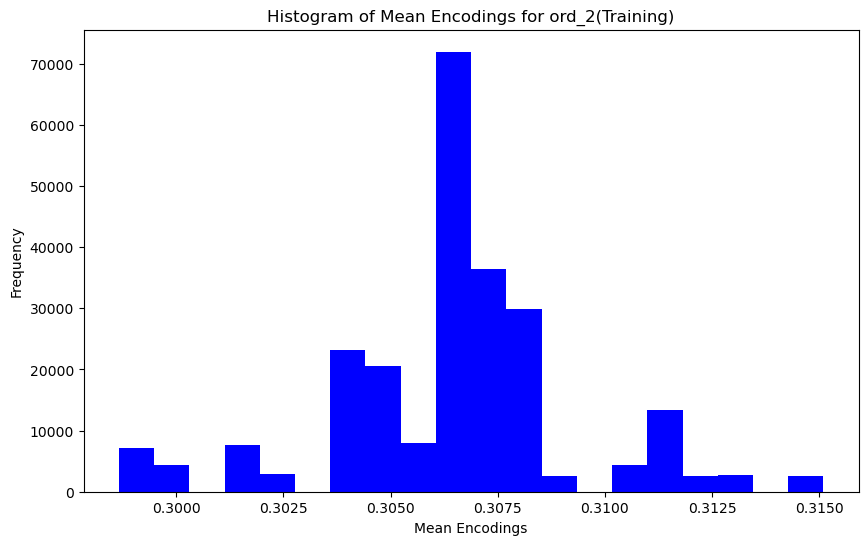

In [28]:
plt.figure(figsize=(10, 6))
plt.hist(X_train['ord_2_mean_enc'], color='blue', bins=20)
plt.title(f'Histogram of Mean Encodings for ord_2(Training)')
plt.xlabel('Mean Encodings')
plt.ylabel('Frequency')
plt.show()

In [29]:
X_train = reg_target_encoding(x_train, y_train, col = 'nom_2', splits = 5)
X_train['nom_2_mean_enc'].describe()

count    240000.000000
mean          0.306471
std           0.002801
min           0.299763
25%           0.305446
50%           0.306492
75%           0.307725
max           0.316799
Name: nom_2_mean_enc, dtype: float64

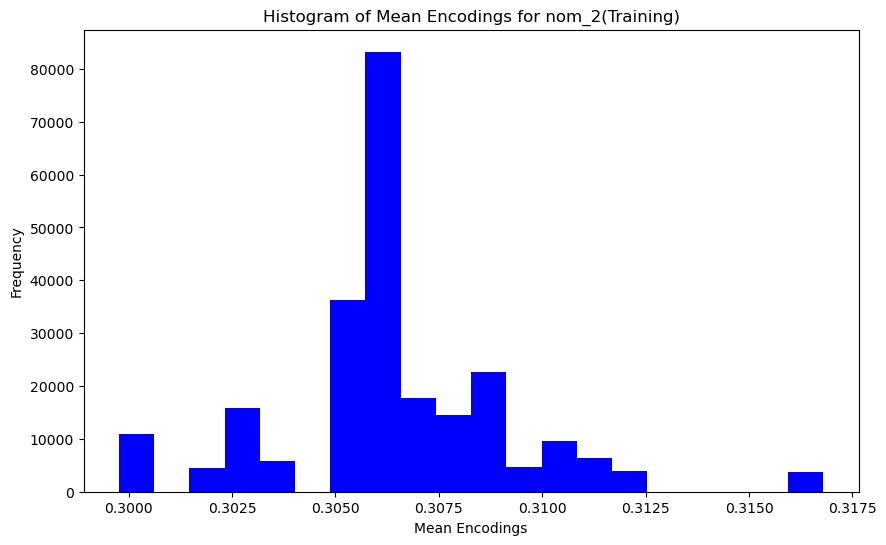

In [30]:
plt.figure(figsize=(10, 6))
plt.hist(X_train['nom_2_mean_enc'], color='blue', bins=20)
plt.title(f'Histogram of Mean Encodings for nom_2(Training)')
plt.xlabel('Mean Encodings')
plt.ylabel('Frequency')
plt.show()

In [31]:
X_test = mean_encoding_test(x_train, y_train, x_test, col = 'ord_2')
X_test['ord_2_mean_enc'].describe()

count    60000.000000
mean         0.306724
std          0.001550
min          0.305060
25%          0.305641
50%          0.306463
75%          0.307674
max          0.310394
Name: ord_2_mean_enc, dtype: float64

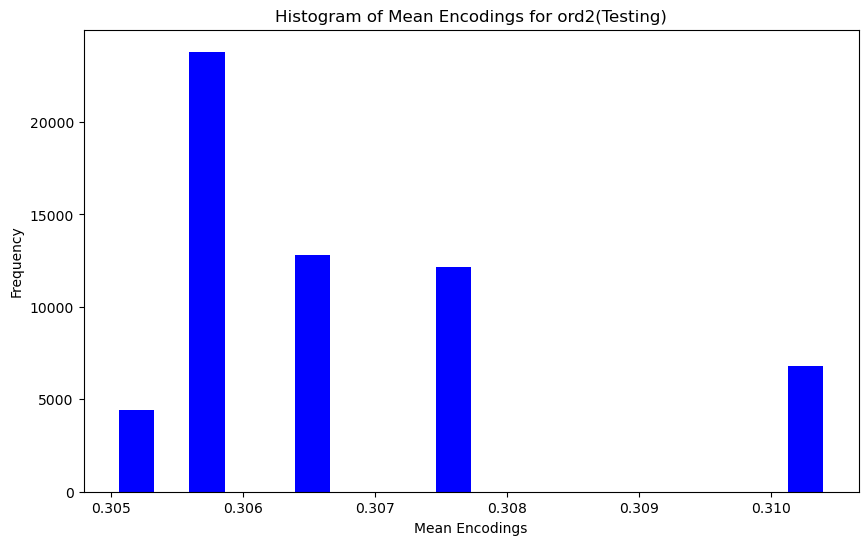

In [32]:
plt.figure(figsize=(10, 6))
plt.hist(X_test['ord_2_mean_enc'], color='blue', bins=20)
plt.title(f'Histogram of Mean Encodings for ord2(Testing)')
plt.xlabel('Mean Encodings')
plt.ylabel('Frequency')
plt.show()

In [33]:
X_test = mean_encoding_test(x_train, y_train, x_test, col = 'nom_2')
X_test['nom_2_mean_enc'].describe()

count    60000.000000
mean         0.306725
std          0.002019
min          0.303286
25%          0.306215
50%          0.306589
75%          0.308923
max          0.308923
Name: nom_2_mean_enc, dtype: float64

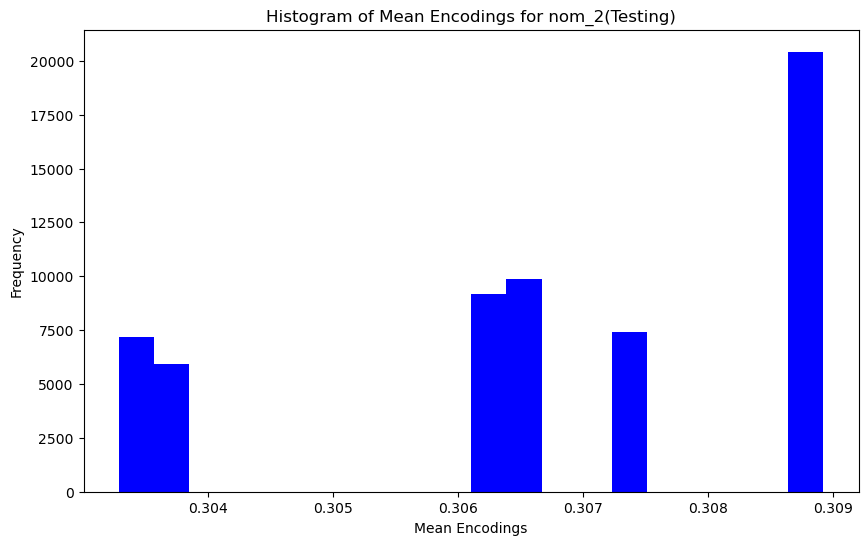

In [34]:
plt.figure(figsize=(10, 6))
plt.hist(X_test['nom_2_mean_enc'], color='blue', bins=20)
plt.title(f'Histogram of Mean Encodings for nom_2(Testing)')
plt.xlabel('Mean Encodings')
plt.ylabel('Frequency')
plt.show()